In [125]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (12, 10)

from subtle.dnn.generators import GeneratorUNet2D
from subtle.data_loaders import SliceLoader
import subtle.utils.io as suio
import subtle.subtle_loss as suloss
import subtle.subtle_metrics as sumetrics
import keras.backend as K
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input as vgg_preprocess
import tensorflow as tf

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

def show_img(img, title='', axis=False, vmin=None, vmax=None):
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args)
    plt.title(title, fontsize=15)
    

def show_comparison(img1, img2, titles=['', ''], vmin=None, vmax=None):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 2, 1)
    show_img(img1, title=titles[0], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 2, 2)
    show_img(img2, title=titles[1], vmin=vmin, vmax=vmax)
    
    plt.show()

def show_gad_comparison(img_pre, img_low, img_post, vmin=None, vmax=None, titles=['Pre contrast', 'Low contrast', 'Full Contrast']):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 3, 1)
    show_img(img_pre, title=titles[0], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 2)
    show_img(img_low, title=titles[1], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 3)
    show_img(img_post, title=titles[2], vmin=vmin, vmax=vmax)

    plt.show()

<Figure size 864x720 with 0 Axes>

In [2]:
fpath_h5 = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO31.h5'
ims = suio.load_file(fpath_h5)
data_zero, data_low, data_full = ims.transpose(1, 0, 2, 3)

In [3]:
K.clear_session()

ckp_file = '/home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/enh_vgg.checkpoint'
data_loader = SliceLoader(
    data_list=[fpath_h5], batch_size=1, shuffle=False, verbose=1,
    slices_per_input=7, resize=240, slice_axis=[0]
)

loss_function = suloss.mixed_loss(l1_lambda=0.3, ssim_lambda=0.3)
metrics_monitor = [suloss.l1_loss, suloss.ssim_loss, suloss.mse_loss]

model = GeneratorUNet2D(
    num_channel_output=1,
    loss_function=loss_function, metrics_monitor=metrics_monitor, verbose=1, checkpoint_file=ckp_file,
    img_rows=240, img_cols=240, num_channel_input=14
)

model.load_weights()

Building unet2d model...
Tensor("model_input:0", shape=(?, 240, 240, 14), dtype=float32)

Tensor("relu_conv_enc_1_2/Relu:0", shape=(?, 240, 240, 32), dtype=float32) Tensor("maxpool_1/MaxPool:0", shape=(?, 120, 120, 32), dtype=float32)
Tensor("relu_conv_enc_2_2/Relu:0", shape=(?, 120, 120, 64), dtype=float32) Tensor("maxpool_2/MaxPool:0", shape=(?, 60, 60, 64), dtype=float32)
Tensor("relu_conv_enc_3_2/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("maxpool_3/MaxPool:0", shape=(?, 30, 30, 128), dtype=float32)
conv center before add Tensor("relu_conv_center/Relu:0", shape=(?, 30, 30, 128), dtype=float32)
conv center... Tensor("add_center/add:0", shape=(?, 30, 30, 128), dtype=float32)
Tensor("relu_conv_dec_2_2/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("cat_1/concat:0", shape=(?, 60, 60, 256), dtype=float32)
Tensor("relu_conv_dec_3_2/Relu:0", shape=(?, 120, 120, 64), dtype=float32) Tensor("cat_2/concat:0", shape=(?, 120, 120, 192), dtype=float32)
Tensor("relu_conv_dec_4

0.6373300795771906


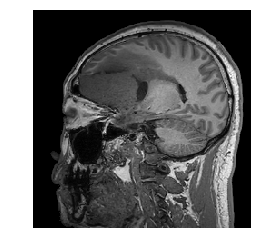

In [4]:
X, Y = data_loader.__getitem__(75)

show_img(X[0, ..., 10])

zero_img = X[0, ..., 3]
low_img = X[0, ..., 10]
full_img = Y[0, ..., 0]

# zero_img = np.interp(zero_img, (zero_img.min(), zero_img.max()), (0, 1))
# low_img = np.interp(low_img, (low_img.min(), low_img.max()), (0, 1))
# full_img = np.interp(full_img, (full_img.min(), full_img.max()), (0, 1))

print(np.mean(np.abs(zero_img - full_img)))

In [177]:
y_true = K.expand_dims(Y[..., 0].astype(np.float32))

# y_pred = np.random.rand(240, 240, 1).astype(np.float32)
y_pred = np.array([low_img]).transpose(1, 2, 0).astype(np.float32)

y_pred = K.constant(np.array([y_pred]))

y_true_3c = K.concatenate([y_true, y_true, y_true])
y_pred_3c = K.concatenate([y_pred, y_pred, y_pred])

y_true_3c = vgg_preprocess(y_true_3c)
y_pred_3c = vgg_preprocess(y_pred_3c)

vgg = VGG19(include_top=False, weights='imagenet', input_shape=(240, 240, 3))
loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
loss_model.trainable = False

loss1 = loss_model(y_true_3c)
loss2 = loss_model(y_pred_3c)

# loss1 = (loss1 / K.max(loss1)) * 100
# loss2 = (loss2 / K.max(loss2)) * 100

# print(K.eval(loss1 - loss2).max())

# loss1 = K.eval(loss1)
# loss2 = K.eval(loss2)

In [178]:
# print(K.eval(K.mean(K.square(loss1 - loss2))))

nrmse = tf.norm(loss1 - loss2) / tf.norm(loss1)
print(K.eval(nrmse))

0.19413851
